#Heart Disease Prediction Logistic Regression

**Import Required Libraries**

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from statsmodels.discrete.discrete_model import Logit
from scipy.special import logit

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Data Preparation**

The dataset was downloaded from the Kaggle website (URL: https://www.kaggle.com/fedesoriano/heart-failure-prediction). It contains 918 observations with 12 features.

In [ ]:
heart_df=pd.read_csv("heart.csv")
heart_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [ ]:
heart_df1=heart_df.copy()
heart_df1.drop(['ChestPainType', 'RestingECG', 'ST_Slope'], axis=1, inplace=True)

The dataset has the following features:

1. **Age**: age of the patient [years]
2. **Sex**: sex of the patient [M: Male, F: Female]
3. **ChestPainType**: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
4. **RestingBP**: resting blood pressure [mm Hg]
5. **Cholesterol**: serum cholesterol [mm/dl]
6. **FastingBS**: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
7. **RestingECG**: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
8. **MaxHR**: maximum heart rate achieved [Numeric value between 60 and 202]
9. **ExerciseAngina**: exercise-induced angina [Y: Yes, N: No]
10. **Oldpeak**: oldpeak = ST [Numeric value measured in depression]
11. **ST_Slope**: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
12. **HeartDisease**: output class [1: heart disease, 0: Normal]

In [ ]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


Overall, the dataset looks prety good. However, there are a couple of columns (i.e. Cholesterol and RestingBP) that have a value of zero (0). A value of zero in these columns does not make sense and indicates an invalid or missing value.

Since there's only one record with missing value in the RestingBP column, we can simply drop that observation.

As for the missing values in the Cholesterol column, it is not wise to just drop them because it impacts roughly 20% of the observations. We don’t want to lose so much information so will impute them with the mean instead.

There are also categorical features which need to be transformed into numeric quantities / dummy variables before we can feed the data into the model.

In [ ]:
# Replace the zero values in FastingBS and Cholesterol columns with NaN
heart_df['RestingBP'] = heart_df['RestingBP'].replace(0, np.nan)
heart_df['Cholesterol'] = heart_df['Cholesterol'].replace(0, np.nan)

# Impute missing values in Cholesterol column with the mean
heart_df['Cholesterol'].fillna((heart_df['Cholesterol'].mean()), inplace=True)

# At this point, only one observation in the dataset has a missing value
# and that is the record with zero RestingBP in the original dataset. 
# We will drop that one observation.
heart_df = heart_df.dropna(axis=0)

**Exploratory Data Visualization**

Generate histograms to help us visualize the distribution of each data.

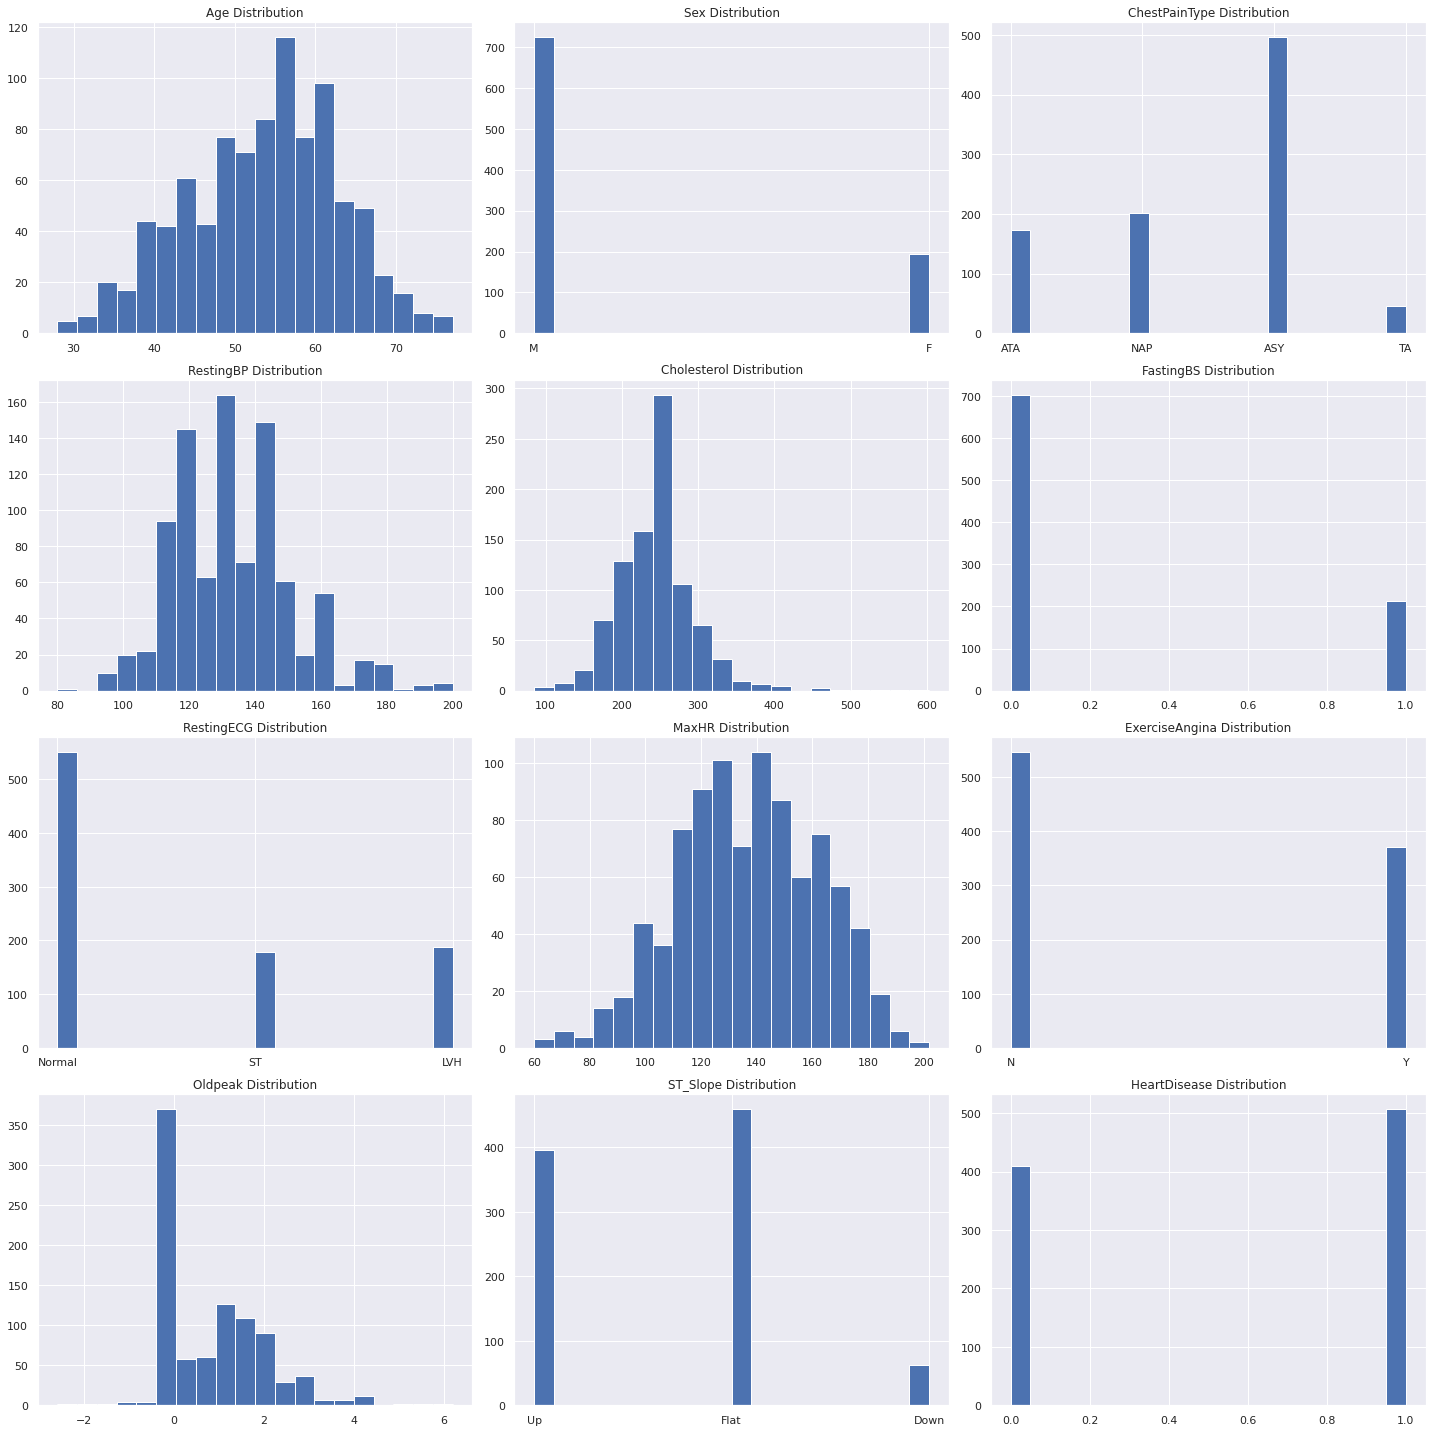

In [ ]:
def draw_histograms(df, predictors, rows, cols):
    fig = plt.figure(figsize=(20,20))
    for i, predictor in enumerate(predictors):
        ax = fig.add_subplot(rows, cols, i+1)
        df[predictor].hist(bins=20, ax=ax)
        ax.set_title(predictor + " Distribution")
    fig.tight_layout()
    plt.show()
draw_histograms(heart_df, heart_df.columns, 4, 3)

**Data Transformation**


Transform the following categorical features into numeric:
1. Sex
2. ExerciseAngina

In [ ]:
heart_df.Sex.replace({'M': 1, 'F': 0}, inplace=True)
heart_df.ExerciseAngina.replace({'Y': 1, 'N': 0}, inplace=True)

Convert the following categorical features into dummy variables:
1. ChestPainType
2. RestingECG
3. ST_Slope

In [ ]:
dummy_ChestPainType = pd.get_dummies(heart_df['ChestPainType'], prefix='ChestPainType', drop_first=True)
heart_df = heart_df.join(dummy_ChestPainType)
dummy_RestingECG = pd.get_dummies(heart_df['RestingECG'], prefix='RestingECG', drop_first=True)
heart_df = heart_df.join(dummy_RestingECG)
dummy_ST_Slope = pd.get_dummies(heart_df['ST_Slope'], prefix='ST_Slope', drop_first=True)
heart_df = heart_df.join(dummy_ST_Slope)

In [ ]:
heart_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ST_Slope_Flat,ST_Slope_Up
0,40,1,ATA,140.0,289.0,0,Normal,172,0,0.0,Up,0,1,0,0,1,0,0,1
1,49,0,NAP,160.0,180.0,0,Normal,156,0,1.0,Flat,1,0,1,0,1,0,1,0
2,37,1,ATA,130.0,283.0,0,ST,98,0,0.0,Up,0,1,0,0,0,1,0,1
3,48,0,ASY,138.0,214.0,0,Normal,108,1,1.5,Flat,1,0,0,0,1,0,1,0
4,54,1,NAP,150.0,195.0,0,Normal,122,0,0.0,Up,0,0,1,0,1,0,0,1


In [ ]:
heart_dfb=heart_df.copy()

In [ ]:
# Fit the model
predictors = ['Age', 'Sex', 'RestingBP', 'Cholesterol', 
              'FastingBS', 'MaxHR', 'ExerciseAngina', 
              'Oldpeak', 'ChestPainType_ATA', 'ChestPainType_NAP', 
              'ChestPainType_TA', 'RestingECG_Normal', 'RestingECG_ST', 
              'ST_Slope_Flat', 'ST_Slope_Up']
m = Logit(heart_dfb['HeartDisease'], heart_dfb[predictors]).fit()
m.summary()

Optimization terminated successfully.
         Current function value: 0.331624
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           HeartDisease   No. Observations:                  917
Model:                          Logit   Df Residuals:                      902
Method:                           MLE   Df Model:                           14
Date:                Tue, 14 Dec 2021   Pseudo R-squ.:                  0.5177
Time:                        00:20:50   Log-Likelihood:                -304.10
converged:                       True   LL-Null:                       -630.48
Covariance Type:            nonrobust   LLR p-value:                3.087e-130
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Age                   0.0084      0.011      0.768      0.442      -0.013       0.030
Sex                   1.5242      0.267      5.719      0.000       1.002       2.047
RestingBP            -0.0014      0.006     -0.248      0.804      -0.013       0.010
Cholesterol           0.0018      0.002      0.931      0.352      -0.002       0.006
FastingBS             1.3403      0.266      5.031      0.000       0.818       1.863
MaxHR                -0.0121      0.004     -3.117      0.002      -0.020      -0.004
ExerciseAngina        0.8381      0.241      3.477      0.001       0.366       1.311
Oldpeak               0.3607      0.116      3.111      0.002       0.133       0.588
ChestPainType_ATA    -1.8915      0.322     -5.872      0.000      -2.523      -1.260
ChestPainType_NAP    -1.6127      0.258     -6.249      0.000      -2.119      -1.107
ChestPainType_TA     -1.4081      0.424     -3.319      0.001      -2.240      -0.577
RestingECG_Normal    -0.1193      0.252     -0.473      0.636      -0.614       0.375
RestingECG_ST        -0.1213      0.332     -0.365      0.715      -0.772       0.529
ST_Slope_Flat         1.0815      0.422      2.564      0.010       0.255       1.908
ST_Slope_Up          -1.2267      0.443     -2.771      0.006      -2.094      -0.359
=====================================================================================
"""

The results tell us that there are predictors with p-value higher than 5%. Such predictors have a low statistically significant relationship with the probability of Heart Disease. We will use Backward Elimination to remove  predictors with the highest p-value one at a time followed by running the regression repeatedly until all attributes have p-value less than 5%.

Create a dataframe containing the predictors and dependent variable that will be fed into the model.

In [ ]:
heart_df_a = heart_dfb[['Age', 'Sex', 'RestingBP', 'Cholesterol', 'FastingBS',
       'MaxHR', 'ExerciseAngina', 'Oldpeak', 
       'ChestPainType_ATA', 'ChestPainType_NAP',
       'ChestPainType_TA', 'RestingECG_Normal', 'RestingECG_ST',
       'ST_Slope_Flat', 'ST_Slope_Up', 'HeartDisease']]
predictors = heart_df_a.columns[:-1]

In [ ]:
def backward_elimination (df, dependent_variable, predictors):
    while len(predictors) > 0:
        m = Logit(df[dependent_variable], df[predictors])
        result = m.fit()        
        largest_pvalue = round(result.pvalues, 3).nlargest(1)
        if (largest_pvalue[0] < (0.05)):
            return result
            break
        else:
            predictors = predictors.drop(largest_pvalue.index)

result = backward_elimination(heart_df_a, 'HeartDisease', predictors)
result.summary()

Optimization terminated successfully.
         Current function value: 0.331624
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.331658
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.331748
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.331816
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.332111
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.332947
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           HeartDisease   No. Observations:                  917
Model:                          Logit   Df Residuals:                      907
Method:                           MLE   Df Model:                            9
Date:                Tue, 14 Dec 2021   Pseudo R-squ.:                  0.5157
Time:                        00:20:51   Log-Likelihood:                -305.31
converged:                       True   LL-Null:                       -630.48
Covariance Type:            nonrobust   LLR p-value:                3.269e-134
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Sex                   1.5574      0.257      6.063      0.000       1.054       2.061
FastingBS             1.3917      0.260      5.351      0.000       0.882       1.902
MaxHR                -0.0096      0.003     -3.308      0.001      -0.015      -0.004
ExerciseAngina        0.8987      0.228      3.935      0.000       0.451       1.346
Oldpeak               0.3952      0.111      3.558      0.000       0.178       0.613
ChestPainType_ATA    -1.9096      0.321     -5.941      0.000      -2.540      -1.280
ChestPainType_NAP    -1.6163      0.257     -6.301      0.000      -2.119      -1.114
ChestPainType_TA     -1.4038      0.419     -3.346      0.001      -2.226      -0.582
ST_Slope_Flat         1.2816      0.362      3.537      0.000       0.572       1.992
ST_Slope_Up          -1.0679      0.397     -2.689      0.007      -1.846      -0.289
=====================================================================================
"""

The results summary of the final model shows that all remaining predictors have a p-value less than 5%. These predictors are:
1. Sex
2. FastingBS
3. MaxHR
4. ExerciseAngina
5. Oldpeak
6. ChestPainType (dummy variables)
7. ST_Slope (dummy variables)

**Derive the estimates of the odds ratio, confidence intervals and p-values**

In [ ]:
params = np.exp(result.params)
conf = np.exp(result.conf_int())
conf['oddsratio'] = params
pvalue = round(result.pvalues,3)
conf['pvalue'] = pvalue
conf.columns = ['CI 95%(2.5%)','CI 95%(97.5%)', 'Odds Ratio', 'pvalue']
conf

,CI 95%(2.5%),CI 95%(97.5%),Odds Ratio,pvalue
Sex,2.868938,7.852380,4.746366,0.000
FastingBS,2.415624,6.696069,4.021838,0.000
MaxHR,0.984843,0.996099,0.990455,0.001
ExerciseAngina,1.570016,3.843474,2.456485,0.000
Oldpeak,1.194234,1.845831,1.484707,0.000
ChestPainType_ATA,0.078894,0.278150,0.148136,0.000
ChestPainType_NAP,0.120146,0.328382,0.198630,0.000
ChestPainType_TA,0.107963,0.559023,0.245670,0.001
ST_Slope_Flat,1.770941,7.327671,3.602342,0.000
ST_Slope_Up,0.157824,0.748647,0.343736,0.007


**Interpretation of the Odds Ratio**

**Sex** - The odds of getting diagnosed with Heart Disease for males over that of females is 4.75. In terms of percent change, we can say that the odds for males getting diagnosed are 375% higher than the odds for females.

**FastingBS** - With an odds ratio of 4.02, patients with fasting blood sugar higher than 120mg/dl are 302% more likely to be diagnosed with heart disease than patients with lower fasting blood sugar levels.

**MaxHR** - An odds ratio close to 1 implies there is equal probability between event and non-event. Therefore, patients with high MaxHR are just as likely to be diagnosed with heart disease as patients with low MaxHR.

**ExerciseAngina** - Patients displaying exercise angina are 146% more likely to have heart disease than patients who do not.

**Oldpeak** - Old peak is a discrete variable defined as the ST segment depression induced by exercise relative to rest, where values higher than 1.5 indicate risk. An odds ratio of 1.48 signifies that with every increase in 1 ST depression, the probability that the patient will be diagnosed with heart disease increases by 48%.

**ChestPainType** - ATA (atypical angina): 0.15, NAP (non-anginal pain): 0.20, TA (typical angina): 0.25. The odds ratios for all three types of chest pain are below 1, signifying that patients with these types of chest pain are less likely to have heart disease, compared to those who have the reference type - asymptomatic. Overall, patients with atypical angina pain are the least likely to have heart disease and are 85% less likely when compared to patients with asymptomic chest pain.

**ST Slope** - Flat: 3.60, up: 0.24. The reference for ST slope is down. Patients with flat ST slope are 260% more likely to have heart disease compared to those with down ST slope. Those with up ST slope are 76% less likely to have heart disease compared to those possessing the reference ST type (i.e. down slope).


**Evaluation Metrics:**

In [ ]:
conf_mat = m.pred_table()
print ('Confusion Matrix:')
print (conf_mat)

Confusion Matrix:
[[341.  69.]
 [ 55. 452.]]


In [ ]:
tn, fp, fn, tp = conf_mat.flatten()
print ('TN, FP, FN, TP:')
print (tn, fp, fn, tp)

TN, FP, FN, TP:
341.0 69.0 55.0 452.0


In [ ]:
acc = (tp + tn) / np.sum(conf_mat)
mcc = (tp * tn - fp * fn)/np.sqrt((tp + fp)*(tp + fn)*(tn + fp)*(tn + fn))
prc = tp / (tp + fp)
rec = tp / (tp + fn)
print ("Accuracy of the model is: %1.2f" % acc)
print ("Mathews correlation coefficient between the estimates and the true response is: %1.2f" % mcc)
print ("Model's precision is %1.2f and its recall is %1.2f" % (prc, rec))

Accuracy of the model is: 0.86
Mathews correlation coefficient between the estimates and the true response is: 0.73
Model's precision is 0.87 and its recall is 0.89


Now, let's plot the ROC curve.

In [ ]:
def plot_ROC (m):
    ths = np.arange(0., 1.0, 0.005)
    sensitivity = []
    specificity = []
    accuracy = []
    matthews = []

    for th in ths:
        conf_mat = m.pred_table(threshold=th)
        tn, fp, fn, tp = conf_mat.flatten()

        sens = (1. * tp) / (tp + fn)
        spec = (1. * tn) / (tn + fp)    
        acc = (tp + tn) / np.sum(conf_mat)
        mcc = (tp * tn - fp * fn)/np.sqrt((tp + fp)*(tp + fn)*(tn + fp)*(tn + fn))

        sensitivity.append(sens)
        specificity.append(spec)
        accuracy.append(acc)
        matthews.append(mcc)

    roc = pd.DataFrame({'discret_thr' : ths, 
              'sensitivity' : sensitivity, 
              'specificity' : specificity,
              '_specificity' : [1 - x for x in specificity],
              'accuracy' : accuracy, 
              'matthews' : matthews})

    roc = roc.sort_values(by = "_specificity")
    auc = np.trapz(y = roc.sensitivity, x = roc._specificity)
    print ("Area under ROC curve = %1.2f" % auc)
    
    J = max(roc.sensitivity + roc.specificity - 1)
    print ('Youden\'s J = %1.2f' % J)
    
    idx_default_th = np.where(roc.discret_thr == 0.5)[0][0]
    idx_youdensj = np.argmax(roc.sensitivity + roc.specificity)
    idx_ballance = np.argmin(np.abs(roc.sensitivity - roc.specificity))
    idx_maxacc = np.argmax(roc.accuracy)
    idx_maxmcc = np.argmax(roc.matthews)
    
    plt.plot(roc._specificity, roc.sensitivity, label = 'ROC')

    plt.plot(np.arange(0., 1., 0.01), 
             np.arange(0., 1., 0.01), 
             '--')

    plt.plot(roc._specificity[idx_default_th], 
             roc.sensitivity[idx_default_th], 
             's', color = 'blue',
             label = 'Default')

    plt.plot(roc._specificity[idx_youdensj], 
             roc.sensitivity[idx_youdensj], 
             's', color = 'red',
             label = 'Max(Spec. + Sens.)')

    plt.plot(roc._specificity[idx_ballance], 
             roc.sensitivity[idx_ballance], 
             's', color = 'green', 
             label = 'Spec. = Sens.')
    
    plt.plot(roc._specificity[idx_maxacc], 
             roc.sensitivity[idx_maxacc], 
             's', color = 'purple',
             label = 'Max. Accuracy')

    plt.plot(roc._specificity[idx_maxmcc], 
             roc.sensitivity[idx_maxmcc], 
             '^', color = 'cyan', 
             label = 'Max. MCC')

    plt.legend(loc = 4)
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.show()

Area under ROC curve = 0.93
Youden's J = 0.74


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


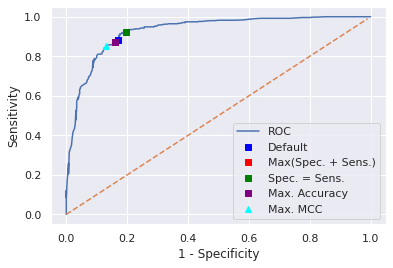

In [ ]:
plot_ROC(result)

**Evaluation of the Logistic Regression Model**

Accuracy, precision, recall and MCC of the model are all fairly close to 1. This indicates that the predictions of whether a patient has Heart Disease, as produced by the model, closely match with the observed results. The ROC curve is close to the error-free point, and Youden's J value is 0.74. As it is fairly close to 1, the value which indicates a perfect model, we can confirm that our model fits the given overall data well. The most significant attributes to be used for predicting heart disease are sex, fasting blood sugar, maximum heart rate, exercise angina, oldpeak, chest pain type and ST slope type.

##Data Segmentation by Sex

As the data includes significant more male patients than female patients, we will look at the two groups separately and determine if there are differences between the significant predictors of heart disease.

**Overview of Data by Sex**

In [ ]:
heart_df_a.groupby(['Sex']).mean()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ST_Slope_Flat,ST_Slope_Up,HeartDisease
Sex,,,,,,,,,,,,,,,
0,52.492228,132.212435,255.139841,0.134715,146.139896,0.222798,0.668912,0.310881,0.274611,0.051813,0.611399,0.145078,0.388601,0.575130,0.259067
1,53.780387,132.628453,241.835169,0.259669,134.296961,0.453039,0.944751,0.156077,0.205801,0.049724,0.598066,0.207182,0.530387,0.392265,0.631215


In [ ]:
heart_df_a.groupby(['Sex']).median()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ST_Slope_Flat,ST_Slope_Up,HeartDisease
Sex,,,,,,,,,,,,,,,
0,53,130.0,244.635389,0,150,0,0.0,0,0,0,1,0,0,1,0
1,55,130.0,244.635389,0,134,0,0.8,0,0,0,1,0,1,0,1


In [ ]:
heart_df_a.groupby(['Sex']).std()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ST_Slope_Flat,ST_Slope_Up,HeartDisease
Sex,,,,,,,,,,,,,,,
0,9.517593,19.392638,61.078028,0.342307,22.154902,0.417206,0.956865,0.464058,0.447479,0.222227,0.488700,0.353095,0.488700,0.495609,0.439262
1,9.404252,17.623033,50.770339,0.438756,25.725467,0.498134,1.087710,0.363180,0.404565,0.217524,0.490628,0.405567,0.499421,0.488593,0.482809


In [ ]:
heart_df_M = heart_df_a[heart_df.Sex == 1]
heart_df_M.drop('Sex',axis=1, inplace=True)
heart_df_F = heart_df_a[heart_df.Sex == 0]
heart_df_F.drop('Sex',axis=1, inplace=True)
heart_df_F.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ST_Slope_Flat,ST_Slope_Up,HeartDisease
1,49,160.0,180.0,0,156,0,1.0,0,1,0,1,0,1,0,1
3,48,138.0,214.0,0,108,1,1.5,0,0,0,1,0,1,0,1
6,45,130.0,237.0,0,170,0,0.0,1,0,0,1,0,0,1,0
9,48,120.0,284.0,0,120,0,0.0,1,0,0,1,0,0,1,0
10,37,130.0,211.0,0,142,0,0.0,0,1,0,1,0,0,1,0


In [ ]:
# Fit the model
predictors_MF = ['Age', 'RestingBP', 'Cholesterol', 
              'FastingBS', 'MaxHR', 'ExerciseAngina', 
              'Oldpeak', 'ChestPainType_ATA', 'ChestPainType_NAP', 
              'ChestPainType_TA', 'RestingECG_Normal', 'RestingECG_ST', 
              'ST_Slope_Flat', 'ST_Slope_Up']
m_M = Logit(heart_df_M['HeartDisease'], heart_df_M[predictors_MF]).fit()
m_F = Logit(heart_df_F['HeartDisease'], heart_df_F[predictors_MF]).fit()

Optimization terminated successfully.
         Current function value: 0.334780
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285432
         Iterations 8


In [ ]:
m_M.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.491     
Dependent Variable: HeartDisease     AIC:              512.7612  
Date:               2021-12-14 00:20 BIC:              576.9482  
No. Observations:   724              Log-Likelihood:   -242.38   
Df Model:           13               LL-Null:          -476.61   
Df Residuals:       710              LLR p-value:      7.2136e-92
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
Age                0.0215   0.0122  1.7601 0.0784 -0.0024  0.0454
RestingBP         -0.0035   0.0065 -0.5379 0.5906 -0.0162  0.0092
Cholesterol        0.0030   0.0023  1.2959 0.1950 -0.0015  0.0075
FastingBS          1.0913   0.2877  3.7931 0.0001  0.5274  1.6551
MaxHR             -0.0091   0.0043 -2.1226 0.0338 -0.0175 -0.0007
ExerciseAngina     0.8566   0.2714  3.1560 0.0016  0.3246  1.3885
Oldpeak            0.3851   0.1306  2.9488 0.0032  0.1291  0.6410
ChestPainType_ATA -1.9850   0.3701 -5.3637 0.0000 -2.7103 -1.2596
ChestPainType_NAP -1.6698   0.2908 -5.7415 0.0000 -2.2398 -1.0998
ChestPainType_TA  -1.3761   0.4673 -2.9448 0.0032 -2.2919 -0.4602
RestingECG_Normal -0.0524   0.2881 -0.1820 0.8556 -0.6170  0.5122
RestingECG_ST     -0.0029   0.3623 -0.0081 0.9935 -0.7130  0.7071
ST_Slope_Flat      1.5278   0.4458  3.4271 0.0006  0.6541  2.4016
ST_Slope_Up       -0.8467   0.4638 -1.8258 0.0679 -1.7557  0.0622
=================================================================

"""

In [ ]:
m_F.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.501     
Dependent Variable: HeartDisease     AIC:              138.1768  
Date:               2021-12-14 00:20 BIC:              183.8545  
No. Observations:   193              Log-Likelihood:   -55.088   
Df Model:           13               LL-Null:          -110.41   
Df Residuals:       179              LLR p-value:      1.3960e-17
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     8.0000                                       
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
Age               -0.0079   0.0286 -0.2765 0.7822 -0.0639  0.0481
RestingBP          0.0193   0.0140  1.3799 0.1676 -0.0081  0.0468
Cholesterol        0.0032   0.0041  0.7664 0.4435 -0.0050  0.0113
FastingBS          3.0468   0.8506  3.5820 0.0003  1.3797  4.7140
MaxHR             -0.0100   0.0100 -0.9989 0.3179 -0.0296  0.0096
ExerciseAngina     0.3649   0.6060  0.6021 0.5471 -0.8229  1.5526
Oldpeak            0.0991   0.3071  0.3227 0.7469 -0.5027  0.7009
ChestPainType_ATA -1.7273   0.7266 -2.3771 0.0174 -3.1515 -0.3031
ChestPainType_NAP -1.6433   0.6855 -2.3971 0.0165 -2.9870 -0.2997
ChestPainType_TA  -3.3364   1.6174 -2.0629 0.0391 -6.5064 -0.1664
RestingECG_Normal  0.3987   0.6090  0.6547 0.5127 -0.7950  1.5924
RestingECG_ST      0.1862   1.0060  0.1851 0.8532 -1.7855  2.1579
ST_Slope_Flat     -1.5941   1.4135 -1.1278 0.2594 -4.3646  1.1763
ST_Slope_Up       -4.4618   1.6868 -2.6451 0.0082 -7.7678 -1.1557
=================================================================

"""

In [ ]:
predictors_MF = heart_df_a[['Age', 'RestingBP', 'Cholesterol', 
              'FastingBS', 'MaxHR', 'ExerciseAngina', 
              'Oldpeak', 'ChestPainType_ATA', 'ChestPainType_NAP', 
              'ChestPainType_TA', 'RestingECG_Normal', 'RestingECG_ST', 
              'ST_Slope_Flat', 'ST_Slope_Up']].columns

In [ ]:
predictors_MF

Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR',
       'ExerciseAngina', 'Oldpeak', 'ChestPainType_ATA', 'ChestPainType_NAP',
       'ChestPainType_TA', 'RestingECG_Normal', 'RestingECG_ST',
       'ST_Slope_Flat', 'ST_Slope_Up'],
      dtype='object')

In [ ]:
result_M = backward_elimination(heart_df_M, 'HeartDisease', predictors_MF)
result_F = backward_elimination(heart_df_F, 'HeartDisease', predictors_MF)

Optimization terminated successfully.
         Current function value: 0.334780
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.334780
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.334812
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.335027
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.336029
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.338658
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285432
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.285521
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.285718
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.285933
  

In [ ]:
result_M.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           HeartDisease   No. Observations:                  724
Model:                          Logit   Df Residuals:                      715
Method:                           MLE   Df Model:                            8
Date:                Tue, 14 Dec 2021   Pseudo R-squ.:                  0.4856
Time:                        00:20:52   Log-Likelihood:                -245.19
converged:                       True   LL-Null:                       -476.61
Covariance Type:            nonrobust   LLR p-value:                 6.521e-95
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Age                   0.0167      0.008      1.991      0.047       0.000       0.033
FastingBS             1.1655      0.282      4.134      0.000       0.613       1.718
MaxHR                -0.0113      0.003     -3.709      0.000      -0.017      -0.005
ExerciseAngina        0.8975      0.264      3.395      0.001       0.379       1.416
Oldpeak               0.4710      0.119      3.956      0.000       0.238       0.704
ChestPainType_ATA    -2.0352      0.367     -5.548      0.000      -2.754      -1.316
ChestPainType_NAP    -1.6826      0.286     -5.876      0.000      -2.244      -1.121
ChestPainType_TA     -1.3717      0.450     -3.047      0.002      -2.254      -0.489
ST_Slope_Flat         2.2237      0.242      9.183      0.000       1.749       2.698
=====================================================================================
"""

In [ ]:
conf_mat_M=result_M.pred_table()
print ('Confusion Matrix:')
print (conf_mat_M)

Confusion Matrix:
[[214.  53.]
 [ 40. 417.]]


In [ ]:
tn_M, fp_M, fn_M, tp_M = conf_mat_M.flatten()
print ('TN, FP, FN, TP:')
print (tn_M, fp_M, fn_M, tp_M)

TN, FP, FN, TP:
214.0 53.0 40.0 417.0


In [ ]:
acc_M = (tp_M + tn_M) / np.sum(conf_mat_M)
mcc_M = (tp_M * tn_M - fp_M * fn_M)/np.sqrt((tp_M + fp_M)*(tp_M + fn_M)*(tn_M + fp_M)*(tn_M + fn_M))
prc_M = tp_M / (tp_M + fp_M)
rec_M = tp_M / (tp_M + fn_M)
print ("Accuracy of the model is: %1.2f" % acc_M)
print ("Mathews correlation coefficient between the estimates and the true response is: %1.2f" % mcc_M)
print ("Model's precision is %1.2f and its recall is %1.2f" % (prc_M, rec_M))

Accuracy of the model is: 0.87
Mathews correlation coefficient between the estimates and the true response is: 0.72
Model's precision is 0.89 and its recall is 0.91


In [ ]:
result_F.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           HeartDisease   No. Observations:                  193
Model:                          Logit   Df Residuals:                      187
Method:                           MLE   Df Model:                            5
Date:                Tue, 14 Dec 2021   Pseudo R-squ.:                  0.4739
Time:                        00:20:52   Log-Likelihood:                -58.092
converged:                       True   LL-Null:                       -110.41
Covariance Type:            nonrobust   LLR p-value:                 5.553e-21
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
RestingBP             0.0060      0.002      2.503      0.012       0.001       0.011
FastingBS             3.0238      0.816      3.704      0.000       1.424       4.624
ChestPainType_ATA    -2.0097      0.648     -3.103      0.002      -3.279      -0.740
ChestPainType_NAP    -2.0142      0.574     -3.509      0.000      -3.139      -0.889
ChestPainType_TA     -3.0558      1.512     -2.021      0.043      -6.019      -0.092
ST_Slope_Up          -3.2138      0.663     -4.846      0.000      -4.514      -1.914
=====================================================================================
"""

In [ ]:
conf_mat_F=result_F.pred_table()
print ('Confusion Matrix:')
print (conf_mat_F)

Confusion Matrix:
[[128.  15.]
 [ 11.  39.]]


In [ ]:
tn_F, fp_F, fn_F, tp_F = conf_mat_F.flatten()
print ('TN, FP, FN, TP:')
print (tn_F, fp_F, fn_F, tp_F)

TN, FP, FN, TP:
128.0 15.0 11.0 39.0


In [ ]:
acc_F = (tp_F + tn_F) / np.sum(conf_mat_F)
mcc_F = (tp_F * tn_F - fp_F * fn_F)/np.sqrt((tp_F + fp_F)*(tp_F + fn_F)*(tn_F + fp_F)*(tn_F + fn_F))
prc_F = tp_F / (tp_F + fp_F)
rec_F = tp_F / (tp_F + fn_F)
print ("Accuracy of the model is: %1.2f" % acc_F)
print ("Mathews correlation coefficient between the estimates and the true response is: %1.2f" % mcc_F)
print ("Model's precision is %1.2f and its recall is %1.2f" % (prc_F, rec_F))

Accuracy of the model is: 0.87
Mathews correlation coefficient between the estimates and the true response is: 0.66
Model's precision is 0.72 and its recall is 0.78


In [ ]:
params_M = np.exp(result_M.params)
conf_M = np.exp(result_M.conf_int())
conf_M['oddsratio'] = params_M
pvalue_M = round(result_M.pvalues,3)
conf_M['pvalue'] = pvalue_M
conf_M.columns = ['CI 95%(2.5%)','CI 95%(97.5%)', 'Odds Ratio', 'pvalue']
conf_M

,CI 95%(2.5%),CI 95%(97.5%),Odds Ratio,pvalue
Age,1.000256,1.033670,1.016826,0.047
FastingBS,1.845982,5.573852,3.207683,0.000
MaxHR,0.982927,0.994702,0.988797,0.000
ExerciseAngina,1.461336,4.119031,2.453423,0.001
Oldpeak,1.268206,2.022474,1.601535,0.000
ChestPainType_ATA,0.063663,0.268144,0.130656,0.000
ChestPainType_NAP,0.106048,0.325833,0.185887,0.000
ChestPainType_TA,0.104967,0.613105,0.253685,0.002
ST_Slope_Flat,5.749469,14.854631,9.241550,0.000


**Interpretation of the Odds Ratio**

**Age** - The odds of getting diagnosed with heart disease for the Age attribute is 1.02. Male patients across all age groups are approximately equally likely to have heart disease. However, for an increase of 1 year, the patient will have a 2% increase in risk of heart disease.

**FastingBS** - With an odds ratio of 3.21, male patients with fasting blood sugar higher than 120 mg/dl are at 3.21 times greater odds to be diagnosed with heart disease than male patients with lower fasting blood sugar levels.

**MaxHR** - The odds of getting diagnosed with heart disease for the MaxHR attribute is 0.99. As the odds ratio is so close to 1, male patients with high and low maximum heart rates are both equally likely to have disease.

**ExerciseAngina** - Patients displaying exercise angina are at 2.45 times greater odds to have heart disease than patients who do not.

**Oldpeak** - An odds ratio of 1.60 signifies that with every increase in 1 ST depression, the probability that the patient will be diagnosed with heart disease increases by 60%.

**ChestPainType** - ATA (atypical angina): 0.15, NAP (non-anginal pain): 0.20, TA (typical angina): 0.25. The odds ratios for all three types of chest pain are below 1, signifying that patients with these types of chest pain are less likely to have heart disease, compared to those who have the reference type - asymptomatic. Overall, patients with atypical angina pain are the least likely to have heart disease and are 85% less likely when compared to patients with asymptomatic chest pain.

**ST Slope** - Flat: 3.60, up: 0.34. The reference for ST slope is down. Patients with flat ST slope are 260% more likely to have heart disease compared to those with down ST slope. Those with up ST slope are 66% less likely to have heart disease compared to those possessing the reference ST type (i.e. down slope).

In [ ]:
params_F = np.exp(result_F.params)
conf_F = np.exp(result_F.conf_int())
conf_F['oddsratio'] = params_F
pvalue_F = round(result_F.pvalues,3)
conf_F['pvalue'] = pvalue_F
conf_F.columns = ['CI 95%(2.5%)','CI 95%(97.5%)', 'Odds Ratio', 'pvalue']
conf_F

,CI 95%(2.5%),CI 95%(97.5%),Odds Ratio,pvalue
RestingBP,1.001295,1.010693,1.005983,0.012
FastingBS,4.153313,101.866877,20.569030,0.000
ChestPainType_ATA,0.037661,0.477006,0.134032,0.002
ChestPainType_NAP,0.043306,0.411054,0.133421,0.000
ChestPainType_TA,0.002432,0.911724,0.047085,0.043
ST_Slope_Up,0.010960,0.147476,0.040204,0.000


**Interpretation of the Odds Ratio**

**RestingBP** - The odds of getting diagnosed with heart disease for the RestingBP attribute is 1.01, indicating that female patients with higher resting blood pressure are at slightly higher risk of having heart disease. For every 1 mm/hg increase in blood pressure, the patient has a 1% increase in probability of heart disease.

**FastingBS** - With an odds ratio of 20.57, female patients with fasting blood sugar higher than 120 mg/dl are at 20.57 times greater odds to be diagnosed with heart disease than female patients with lower fasting blood sugar levels.

**ChestPainType** - ATA (atypical angina): 0.13, NAP (non-anginal pain): 0.13, TA (typical angina): 0.05. The odds ratios for all three types of chest pain are below 1, signifying that patients with these types of chest pain are less likely to have heart disease, compared to those who have asymptomatic pain. Patients with atypical angina and non-anginal pain are both 87% less likely, and patients with atypical angina are 95% less likely to have heart disease compared to patients with asymptomatic chest pain.

**ST Slope** - With an odd ratio of 0.04 for up, female patients with up ST slope are 96% less likely to have heart disease than those with down ST slope. Flat ST slope was eliminated due statistical insignificance.

**ROC**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


Area under ROC curve = 0.92
Youden's J = 0.72


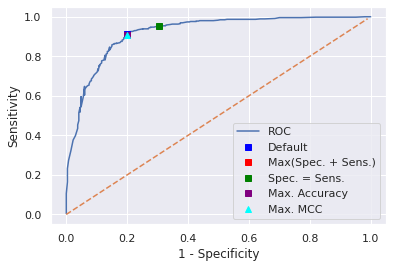

In [ ]:
plot_ROC(result_M)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


Area under ROC curve = 0.93
Youden's J = 0.72


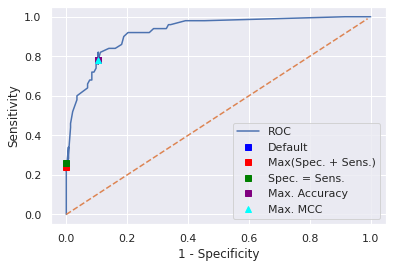

In [ ]:
plot_ROC(result_F)